# Run PEST and Parallel PEST
### This should be super easy ~

In [1]:
import os
import shutil
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;
import psutil
import sys
import pyemu
import flopy
import swatp_pst
assert "dependencies" in flopy.__file__
assert "dependencies" in pyemu.__file__
assert "dependencies" in swatp_pst.__file__

# 01. Specify a path to the model folder

In [2]:
# path to project directory
prj_dir = "D:\\spark\\jj\\opt_2nd" # win
# prj_dir = "/Users/seonggyu.park/Documents/projects/jj" #mac

In [3]:
main_opt_path = os.path.join(prj_dir, 'main_opt')
os.chdir(main_opt_path)

In [4]:
os.getcwd()

'D:\\spark\\jj\\opt_2nd\\main_opt'

# 02. Initial run for adjusting weights

In [5]:
# PEST control file name
pst_name = "swatp_dummy.pst"

In [29]:
# initial run
# pyemu.os_utils.run(f'pestpp-glm.exe {pst_name}' , cwd=".")

## 02-01 Change weights to make all of observation data visible 

In [30]:
# reweight
pst = pyemu.Pst(pst_name)
pst.phi

2033.2332590533408

In [ ]:
# you can assign any values to balanced phi value for each group
# balanced_groups = {grp:1000 for grp in pst.nnz_obs_groups}
# pst.adjust_weights(obsgrp_dict=balanced_groups)

In [8]:
# Let's create a new control file with the number of iterations set to 30 and incorporate reweighted factors.
# pst.control_data.noptmax = 30
# pst.write(os.path.join(main_opt_path,'swatp_test_nweight.pst'), version=2)

noptmax:30, npar_adj:5, nnz_obs:124


# 03. Perform uncertainty analysis with IES

In [6]:
# check the number of available cores
num_workers = psutil.cpu_count(logical=False)
num_workers

96

In [7]:
main_opt_path

'D:\\spark\\jj\\opt_2nd\\main_opt'

In [9]:
pst_ies = pyemu.Pst(os.path.join(main_opt_path,"swatp_dummy.pst"))
# set IES
pst_ies.pestpp_options['ies_num_reals'] = 200 # number of realization
pst_ies.control_data.noptmax = 10 # number of iteration
pst_ies.write('swatp_nw_ies.pst', version=2) # write new IES control file

noptmax:10, npar_adj:10, nnz_obs:124


In [10]:
# set a path to the main directory of model
m_d = os.path.join(prj_dir, "swatp_nw_ies")

In [11]:
m_d

'D:\\spark\\jj\\opt_2nd\\swatp_nw_ies'

In [ ]:
os.chdir(prj_dir) # move the loction to project directory
# run PEST in parallel
pyemu.os_utils.start_workers(
                            main_opt_path, # the folder which contains the "template" PEST dataset
                            "pestpp-ies", #the PEST software version we want to run
                            'swatp_nw_ies.pst', # the control file to use with PEST
                            num_workers=num_workers, #how many agents to deploy
                            worker_root='.', #where to deploy the agent directories; relative to where python is running
                            master_dir=m_d, #the manager directory,
                            # reuse_master=True
                            )

# 03. Let's see how we did:

In [4]:
from swatp_pst import analyzer

In [5]:
m_d = 'D:\\jj\\jj\\swatp_nw_ies'

In [6]:
pst_file = "swatp_nw_ies.pst"
pst = pyemu.Pst(os.path.join(m_d, pst_file))

### 03.01 phi progress

In [7]:
pst.phi

948.3773192595701

In [8]:
# plot phi progress
# pyemu.plot_utils.phi_progress(pst)

In [9]:
pst_file = "swatp_nw_ies.pst"
pst = pyemu.Pst(os.path.join(m_d, pst_file))

In [10]:
# load prior simulation
pr_oe = pyemu.ObservationEnsemble.from_csv(
    pst=pst,filename=os.path.join(m_d,"swatp_nw_ies.0.obs.csv")
    )
# load posterior simulation
pt_oe = pyemu.ObservationEnsemble.from_csv(
    pst=pst,
    filename=os.path.join(m_d,"swatp_nw_ies.{0}.obs.csv".format(4))
    )

In [11]:
opt_df = analyzer.create_stf_opt_df(pst, pt_oe, opt_idx=-1)

In [12]:
m_d2 = 'D:\\jj\\TxtInOut_Imsil_rye_rot_r2'

In [13]:
org_sim = analyzer.create_stf_sim_obd_df(m_d2, 1, "singi_obs_q1_colnam.csv", "cha01")

In [14]:
org_sim

,flo_out,obsval,time
2013-01-31,0.3507,1.5,2013-01-31
2013-02-28,1.0420,2.3,2013-02-28
2013-03-31,1.7200,2.7,2013-03-31
2013-04-30,0.4427,1.6,2013-04-30
2013-05-31,1.1730,2.2,2013-05-31
...,...,...,...
2023-07-31,38.7000,27.5,2023-07-31
2023-08-31,7.0330,7.9,2023-08-31
2023-09-30,2.9410,5.3,2023-09-30
2023-10-31,0.1964,1.6,2023-10-31


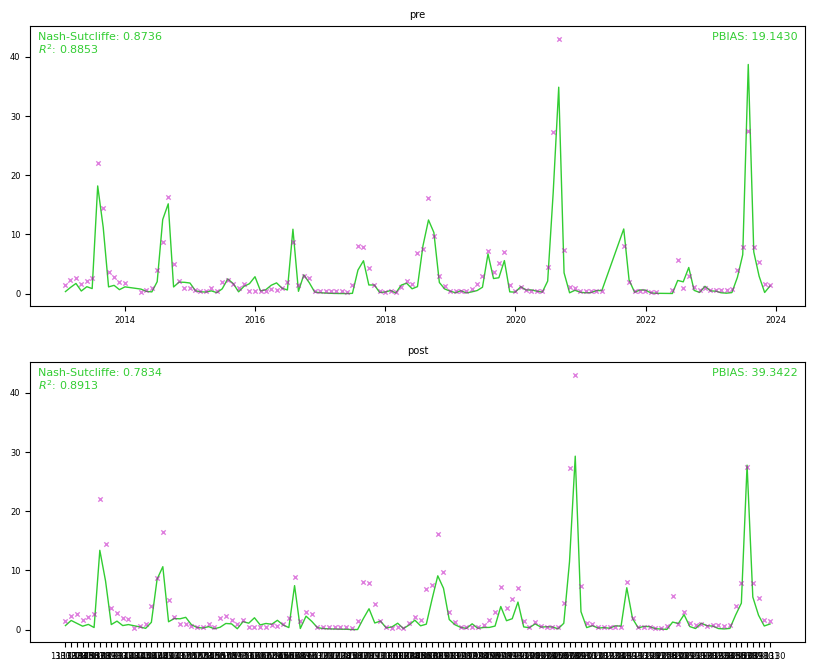

In [16]:
# plot progress comparison pre and post
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
analyzer.plot_stf_sim_obd(axes[0], org_sim, dot=True)
analyzer.plot_stf_sim_obd(axes[1], opt_df, dot=True)
axes[0].set_title('pre')
axes[1].set_title('post')
plt.show()

In [ ]:
# plot progress
fig,ax = plt.subplots(1,1)
pr_oe.phi_vector.apply(np.log10).hist(ax=ax,fc="0.5",ec="none",alpha=0.5,density=False)
pt_oe.phi_vector.apply(np.log10).hist(ax=ax,fc="b",ec="none",alpha=0.5,density=False)
_ = ax.set_xlabel("$log_{10}\\phi$")

<Figure size 800x1050 with 0 Axes>

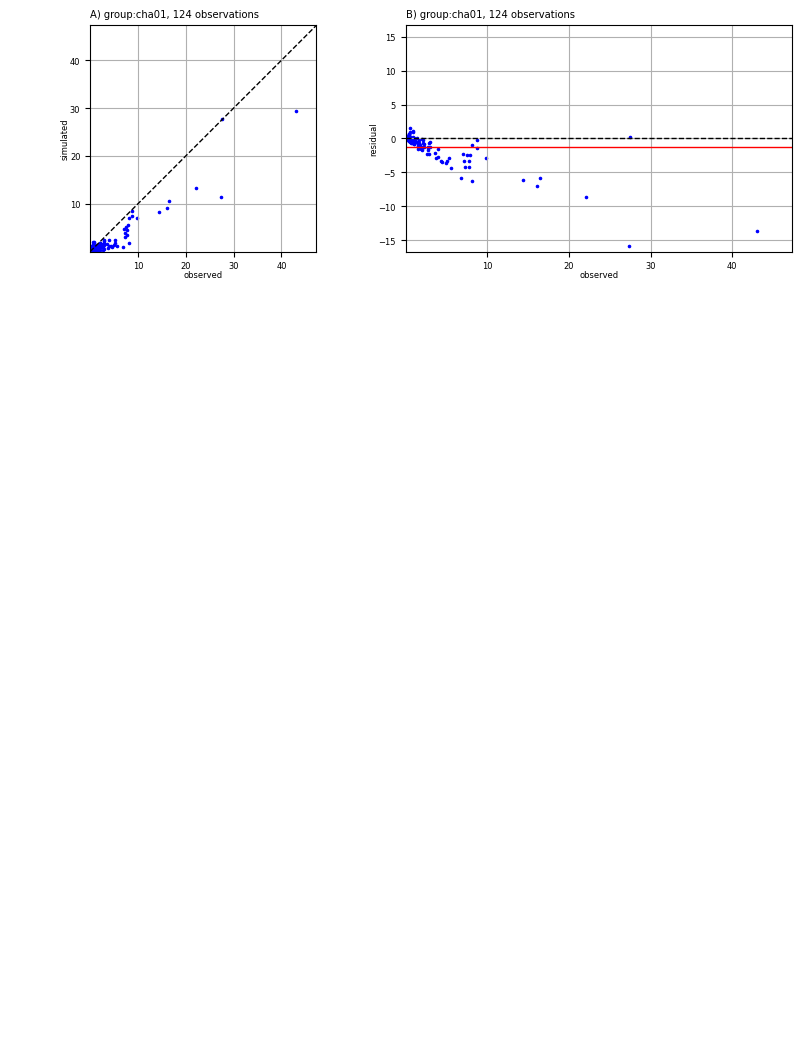

In [27]:
# plot 1 to 1 scatter plot and residuals
pyemu.plot_utils.res_1to1(pst);

## 03.02 Predictive uncertainty

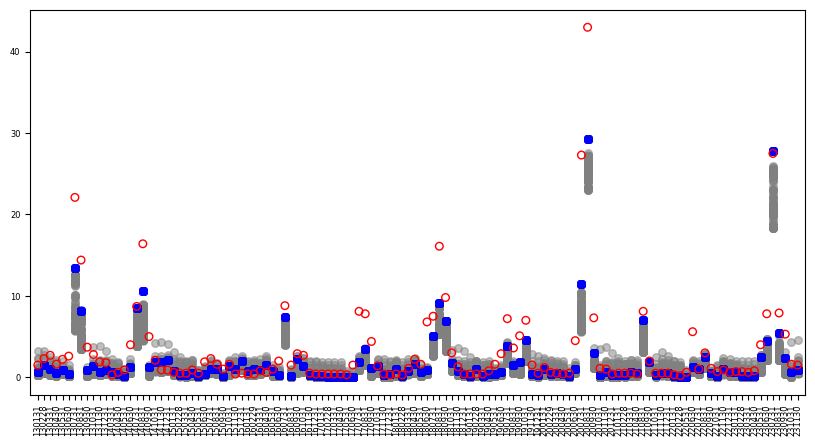

In [25]:
analyzer.single_plot_tseries_ensembles(pst, pr_oe, pt_oe, width=10, height=5, dot=True)

## 03.03 Parameter uncertainty

In [41]:
prior_df = pyemu.ParameterEnsemble.from_csv(
    pst=pst,filename=os.path.join(m_d,"swatp_nw_ies.{0}.par.csv".format(0)))
post_df = pyemu.ParameterEnsemble.from_csv(
    pst=pst,filename=os.path.join(m_d,"swatp_nw_ies.{0}.par.csv".format(4)))

In [43]:
df_pars = pd.read_csv(os.path.join(m_d, "swatp_nw_ies.par_data.csv"))
sel_pars = df_pars.loc[df_pars["partrans"]=='log']
sel_pars

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
0,alpha,log,factor,0.00001,1.000000e-06,1.0,pargp,1.0,0.0,1
1,awc,log,factor,100.00001,1.000000e+00,199.0,pargp,1.0,-100.0,1
2,cn2,log,factor,84.92879,1.000000e+00,199.0,pargp,1.0,-100.0,1
3,esco,log,factor,0.00001,1.000000e-07,1.0,pargp,1.0,0.0,1
4,surlag,log,factor,0.10000,5.000000e-02,24.0,pargp,1.0,0.0,1


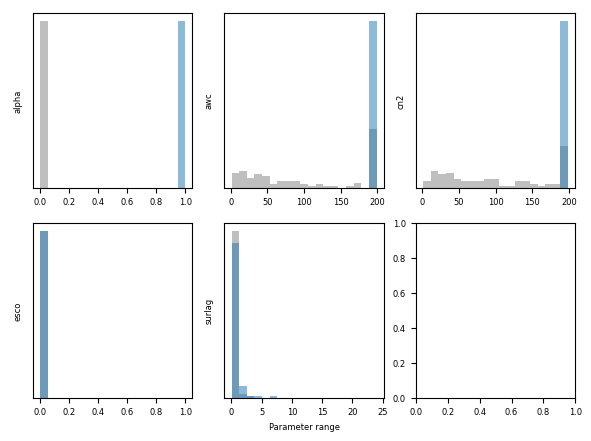

In [44]:
analyzer.plot_prior_posterior_par_hist(prior_df, post_df, sel_pars)

# 04 updates the model input files with parameter values

In [8]:
m_d

'D:\\jj\\jj\\swatp_nw_ies'

In [12]:
pst.parrep(parfile=os.path.join(m_d, "swatp_nw_ies.{0}.base.par".format(4)))
# updates the model input files with parameter values
pst.write_input_files(pst_path=m_d)
# run the model forward run; this applies all the SWAT+ paarameters, executes SWAT+ 
os.chdir(m_d)
pyemu.os_utils.run('python forward_run.py')

Updating parameter values from D:\jj\jj\swatp_nw_ies\swatp_nw_ies.4.base.par
parrep: updating noptmax to 0


Exception: run() returned non-zero: 1

In [ ]:
pyemu.os_utils.run("python forward_run.py",cwd=m_d)